In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import os

FILE_NAME = "earthquake_data_1months.csv"

def fetch_earthquake_data(start_time, end_time, min_magnitude="1.0"):
    """
    Fetch earthquake data from USGS API given a start time and end time.
    The times are formatted without microseconds to comply with the API.
    """
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    # Format times to remove microseconds
    start_time_str = start_time.strftime('%Y-%m-%dT%H:%M:%S')
    end_time_str = end_time.strftime('%Y-%m-%dT%H:%M:%S')

    params = {
        "format": "geojson",
        "starttime": start_time_str,
        "endtime": end_time_str,
        "minmagnitude": min_magnitude
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        features = data.get("features", [])
        records = []
        for feature in features:
            props = feature.get("properties", {})
            geom = feature.get("geometry", {})
            coords = geom.get("coordinates", [None, None, None])
            record = {
                "time": pd.to_datetime(props.get("time"), unit="ms"),
                "place": props.get("place"),
                "magnitude": props.get("mag"),
                "longitude": coords[0],
                "latitude": coords[1],
                "depth": coords[2]
            }
            records.append(record)
        return pd.DataFrame(records)
    else:
        print("Error fetching data:", response.status_code)
        return pd.DataFrame()

def initialize_data():
    """
    If the CSV file exists, load it. Otherwise, fetch historical data for the past 4 months,
    save it to CSV, and return the DataFrame.
    """
    if os.path.exists(FILE_NAME):
        df = pd.read_csv(FILE_NAME, parse_dates=["time"])
        print("Loaded existing data with {} records.".format(len(df)))
        return df
    else:
        end_time = datetime.utcnow()
        start_time = end_time - timedelta(days=30)  # approx. 4 months
        print("Fetching historical data from {} to {}...".format(
            start_time.strftime('%Y-%m-%dT%H:%M:%S'),
            end_time.strftime('%Y-%m-%dT%H:%M:%S')
        ))
        df = fetch_earthquake_data(start_time, end_time, min_magnitude="1.0")
        if not df.empty:
            df.to_csv(FILE_NAME, index=False)
            print("Historical data saved with {} records.".format(len(df)))
        else:
            print("No historical data fetched.")
        return df

def update_data(existing_df):
    """
    Fetch new data from the last recorded time until now, update the CSV, and return the updated DataFrame.
    """
    if existing_df.empty:
        last_time = datetime.utcnow() - timedelta(days=30)
    else:
        last_time = existing_df["time"].max()

    current_time = datetime.utcnow()
    print("Fetching new data from {} to {}...".format(
        last_time.strftime('%Y-%m-%dT%H:%M:%S'),
        current_time.strftime('%Y-%m-%dT%H:%M:%S')
    ))
    new_data_df = fetch_earthquake_data(last_time, current_time, min_magnitude="1.0")

    if not new_data_df.empty:
        updated_df = pd.concat([existing_df, new_data_df]).drop_duplicates(subset=["time", "place", "magnitude"])
        updated_df.to_csv(FILE_NAME, index=False)
        print("Data updated successfully. New records added: {}".format(len(new_data_df)))
        return updated_df
    else:
        print("No new data found.")
        return existing_df

# Initialize or load historical data for the past 4 months
df = initialize_data()
print(df.head())


Loaded existing data with 6030 records.
                     time                                     place  \
0 2025-04-01 08:36:30.790  40 km SE of Denali National Park, Alaska   
1 2025-04-01 08:31:53.019               69 km NW of Yakutat, Alaska   
2 2025-04-01 07:47:24.140            16 km NNE of Yerington, Nevada   
3 2025-04-01 07:46:05.482         26 km NNW of Shoshone, California   
4 2025-04-01 07:20:48.943               61 km ESE of Egegik, Alaska   

   magnitude  longitude  latitude  depth  
0        2.5  -151.1113   63.3032    1.3  
1        1.5  -140.6746   59.9508   15.0  
2        1.6  -119.1109   39.1278    4.3  
3        1.2  -116.3562   36.2030    2.3  
4        1.4  -156.3555   58.1073    9.7  


In [ ]:
# Continuous update loop (every 10 minutes)
#while True:
#    time.sleep(600)  # Sleep for 10 minutes (600 seconds)
df = update_data(df)

Fetching new data from 2025-04-01T08:36:30 to 2025-04-01T08:41:56...
Data updated successfully. New records added: 1


In [ ]:
import pandas as pd
import numpy as np

# Load the earthquake data from the CSV file (data from the past 30 days in this example)
df = pd.read_csv("earthquake_data_1months.csv", parse_dates=["time"])

# For finer granularity, floor the event times to the hour
df['hour'] = df['time'].dt.floor('h')

# Display a sample of the data
print("Sample event-level data:")
print(df.head())

Sample event-level data:
                     time                                     place  \
0 2025-04-01 08:36:30.790  40 km SE of Denali National Park, Alaska   
1 2025-04-01 08:31:53.019               69 km NW of Yakutat, Alaska   
2 2025-04-01 07:47:24.140            16 km NNE of Yerington, Nevada   
3 2025-04-01 07:46:05.482         26 km NNW of Shoshone, California   
4 2025-04-01 07:20:48.943               61 km ESE of Egegik, Alaska   

   magnitude  longitude  latitude  depth                hour  
0        2.5  -151.1113   63.3032    1.3 2025-04-01 08:00:00  
1        1.5  -140.6746   59.9508   15.0 2025-04-01 08:00:00  
2        1.6  -119.1109   39.1278    4.3 2025-04-01 07:00:00  
3        1.2  -116.3562   36.2030    2.3 2025-04-01 07:00:00  
4        1.4  -156.3555   58.1073    9.7 2025-04-01 07:00:00  


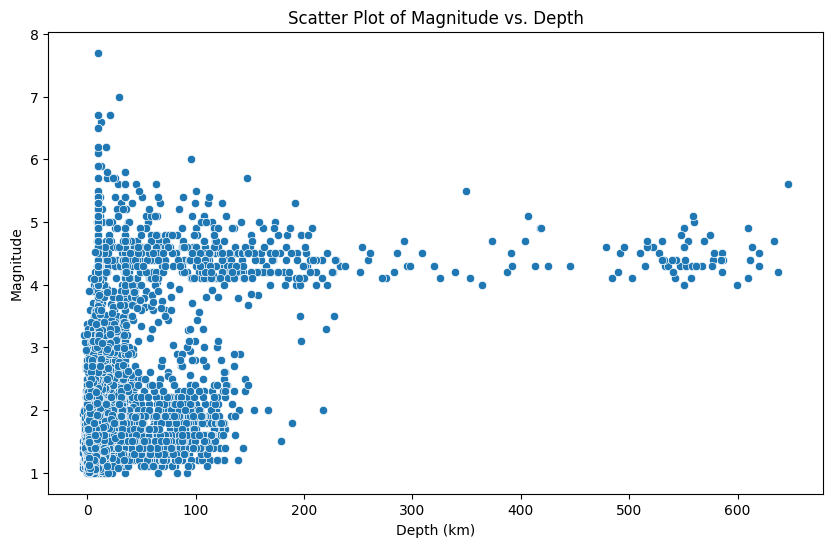

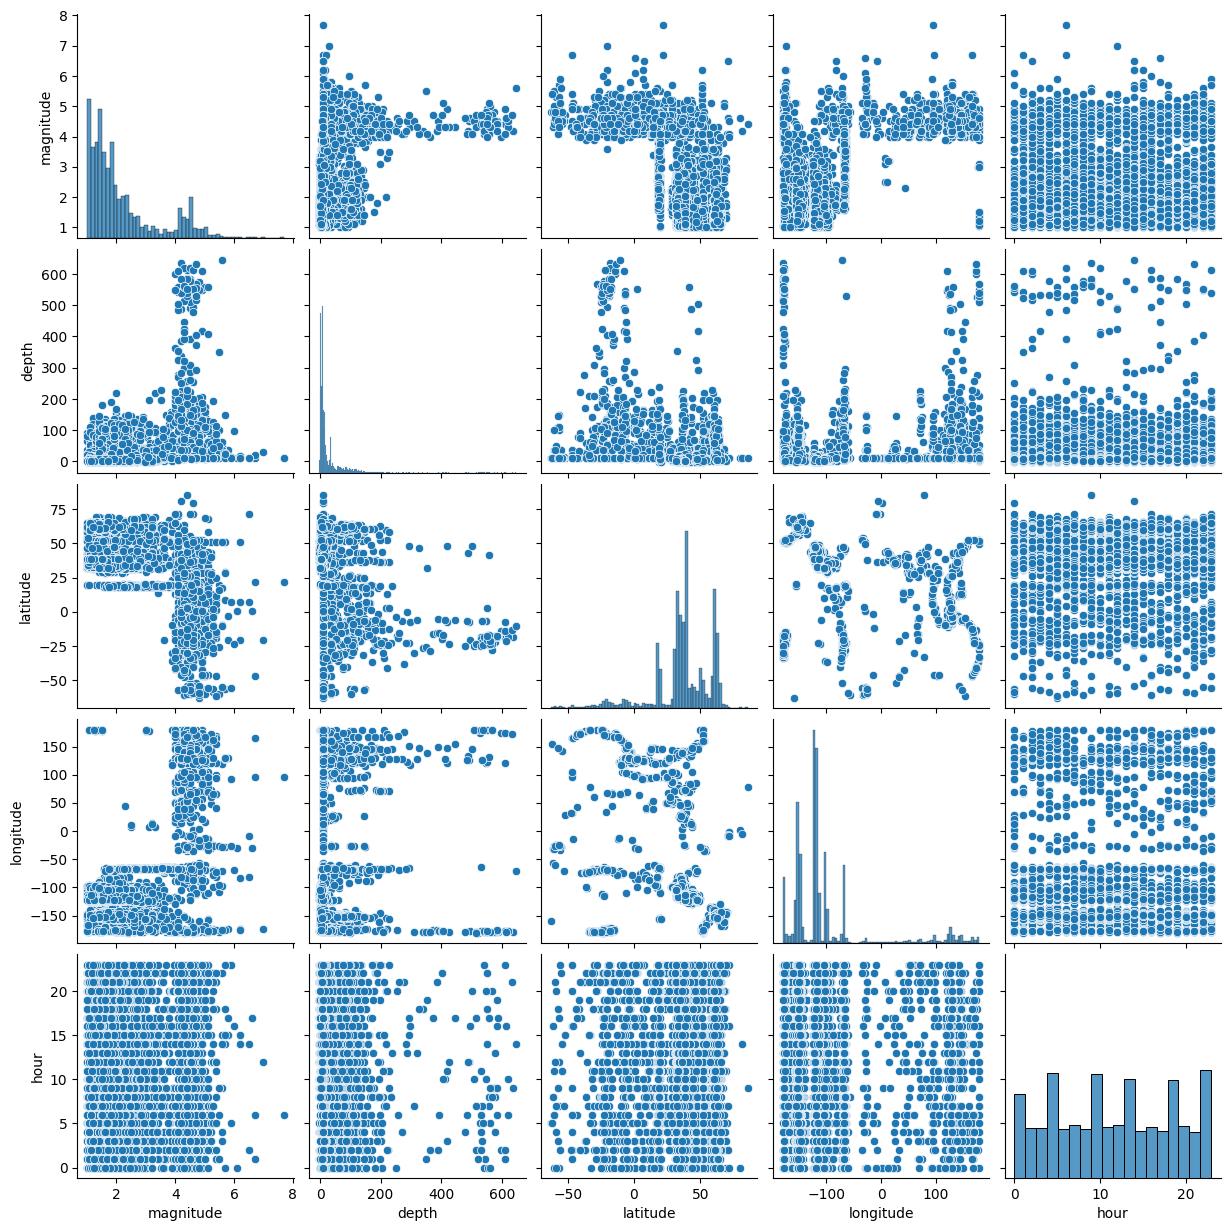

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (assumed to have 6060 rows and columns: time, place, magnitude, longitude, latitude, depth)
df = pd.read_csv("earthquake_data_1months.csv", parse_dates=["time"])

# Create additional time features
df['month'] = df['time'].dt.month
df['hour'] = df['time'].dt.hour

# Example: Visualize relationships between magnitude, depth, latitude, and hour.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='depth', y='magnitude', data=df)
plt.title("Scatter Plot of Magnitude vs. Depth")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.show()

# Use a pairplot to visualize pairwise relationships
sns.pairplot(df[['magnitude', 'depth', 'latitude', 'longitude', 'hour']])
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Load the earthquake data
df = pd.read_csv("earthquake_data_1months.csv", parse_dates=["time"])

# Create new time-based features
df['hour'] = df['time'].dt.hour
df['day_of_year'] = df['time'].dt.dayofyear

# Select features and target
# We use latitude, longitude, depth, hour, and day_of_year as predictors for magnitude.
features = ['latitude', 'longitude', 'depth', 'hour', 'day_of_year']
target = 'magnitude'

# Display a preview of the engineered features
print(df[features + [target]].head())


   latitude  longitude  depth  hour  day_of_year  magnitude
0   63.3032  -151.1113    1.3     8           91        2.5
1   59.9508  -140.6746   15.0     8           91        1.5
2   39.1278  -119.1109    4.3     7           91        1.6
3   36.2030  -116.3562    2.3     7           91        1.2
4   58.1073  -156.3555    9.7     7           91        1.4


In [ ]:
import statsmodels.api as sm

# Prepare the predictor matrix X and response vector Y
X = df[features]
Y = df[target]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(Y, X).fit()

# Display the summary which includes F-test and t-test results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              magnitude   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     1246.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        08:42:04   Log-Likelihood:                -7244.7
No. Observations:                6030   AIC:                         1.450e+04
Df Residuals:                    6024   BIC:                         1.454e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.1285      0.098     31.971      

The output provides several key pieces of information about the relationship between earthquake magnitude and the predictors (latitude, longitude, depth, hour, and day_of_year):

Overall Model Fit:

R-squared (0.506): About 50.6% of the variability in earthquake magnitude is explained by the predictors in the model.

F-statistic (1241) with a p-value of 0.00: This indicates that, as a group, the predictors significantly affect earthquake magnitude. In other words, you reject the null hypothesis that none of the predictors are related to magnitude.

Individual Predictor Significance (t-tests):

Latitude:

Coefficient: -0.0158

p-value: 0.000
This suggests that, holding other variables constant, an increase in latitude is associated with a decrease in magnitude. The effect is statistically significant.

Longitude:

Coefficient: 0.0061

p-value: 0.000
An increase in longitude is associated with an increase in magnitude, and this effect is statistically significant.

Depth:

Coefficient: 0.0040

p-value: 0.000
A deeper earthquake tends to have a slightly higher magnitude, and this relationship is statistically significant.

Hour:

Coefficient: -0.0005

p-value: 0.717
The hour of the day does not have a statistically significant effect on magnitude.

Day_of_year:

Coefficient: 0.0013

p-value: 0.294
The day of the year is also not a significant predictor of magnitude in this model.


Inference
Rejecting the Null Hypothesis:
The overall model is statistically significant, so we reject the null hypothesis that earthquake magnitude is not affected by the predictors.

Significant Predictors:
Latitude, longitude, and depth have significant impacts on earthquake magnitude. In contrast, hour and day_of_year do not appear to significantly affect the magnitude.

Practical Implications:
These results suggest that the geographical location (captured by latitude and longitude) and the depth of an earthquake are important factors in determining its magnitude. Temporal factors like the time of day or the day of the year, at least in this simple model, do not show a strong relationship with magnitude.

This analysis supports the idea that when predicting earthquake characteristics, location and depth should be prioritized as features over the simple temporal features used here. Further model refinement could involve exploring interaction terms or non-linear relationships to capture more complex dynamics.

In [ ]:
import pandas as pd
import folium
import ipywidgets as widgets
from IPython.display import display

# Load the earthquake data
df = pd.read_csv("earthquake_data_1months.csv", parse_dates=["time"])

# Function to create a folium map based on filter parameters
def create_map(min_magnitude=1.0, start_date=None, end_date=None):
    # Filter the data based on magnitude and date range
    filtered = df[df["magnitude"] >= min_magnitude].copy()
    if start_date:
        filtered = filtered[filtered["time"] >= pd.to_datetime(start_date)]
    if end_date:
        filtered = filtered[filtered["time"] <= pd.to_datetime(end_date)]

    if filtered.empty:
        print("No records found for the selected filters.")
        return folium.Map(location=[0, 0], zoom_start=2)

    # Center the map on the mean latitude and longitude
    center = [filtered["latitude"].mean(), filtered["longitude"].mean()]
    m = folium.Map(location=center, zoom_start=2)

    # Plot each earthquake with a circle marker, where the radius is scaled by magnitude
    for idx, row in filtered.iterrows():
        popup = (f"<b>Time:</b> {row['time']}<br>"
                 f"<b>Magnitude:</b> {row['magnitude']}<br>"
                 f"<b>Depth:</b> {row['depth']} km<br>"
                 f"<b>Location:</b> {row['place']}")
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=row["magnitude"] * 2,  # scaling factor for visibility
            color="red",
            fill=True,
            fill_opacity=0.6,
            popup=popup
        ).add_to(m)

    return m

# Create interactive widgets for filtering
min_magnitude_widget = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.1, description="Min Magnitude:"
)
start_date_widget = widgets.DatePicker(
    value=pd.to_datetime("2025-01-01").date(), description="Start Date:"
)
end_date_widget = widgets.DatePicker(
    value=pd.to_datetime("2025-03-30").date(), description="End Date:"
)

# Function that updates the map based on widget inputs
def update_map(min_magnitude, start_date, end_date):
    m = create_map(min_magnitude, start_date, end_date)
    display(m)

# Use interactive_output to link the widgets to the update function
ui = widgets.HBox([min_magnitude_widget, start_date_widget, end_date_widget])
out = widgets.interactive_output(update_map, {
    "min_magnitude": min_magnitude_widget,
    "start_date": start_date_widget,
    "end_date": end_date_widget
})

# Display the widgets and the map output inline
display(ui, out)


Output()

**Idhar tak sab sahi hai**

**Iske aage model banana hai**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
import folium
from datetime import timedelta

# Load the dataset
df = pd.read_csv("/content/earthquake_data_1months.csv", parse_dates=["time"])

# Feature Engineering
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour
df["day_of_year"] = df["time"].dt.dayofyear
df["magnitude_rolling"] = df["magnitude"].rolling(10, min_periods=1).mean()
df["depth_rolling"] = df["depth"].rolling(10, min_periods=1).mean()
df["timestamp"] = df["time"].astype(int) // 10**9  # Convert datetime to Unix timestamp
df.drop(columns=["place", "time"], inplace=True)

# Splitting data
features = ["latitude", "longitude", "depth", "magnitude", "year", "month", "day", "hour", "day_of_year", "magnitude_rolling", "depth_rolling", "timestamp"]
targets = ["latitude", "longitude", "depth", "magnitude", "timestamp"]

X = df[features]
y = df[targets]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# LSTM Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='linear')  # Predicting latitude, longitude, depth, magnitude, and timestamp
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=20, batch_size=32, validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test))

# XGBoost Classifier for Probability Estimation
probability_model = XGBClassifier()
y_prob = (y["magnitude"] > 3.5).astype(int)  # Label earthquakes above 3.5 as significant
probability_model.fit(X_train, y_prob[:len(X_train)])
predicted_probabilities = probability_model.predict_proba(X_test)[:, 1]

# Predict Next 7 Days
future_predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
future_predictions = scaler_y.inverse_transform(future_predictions)

# Get the last known timestamp from the dataset
last_known_timestamp = df["timestamp"].max()
start_date = pd.Timestamp.utcfromtimestamp(last_known_timestamp)

# Generate future timestamps strictly within the next 7 days
num_predictions = len(future_predictions)
future_dates = [start_date + timedelta(days=(i % 7)) for i in range(num_predictions)]

# Store Predictions in DataFrame
predictions_df = pd.DataFrame(future_predictions, columns=["latitude", "longitude", "depth", "magnitude", "timestamp"])
predictions_df["date"] = future_dates
predictions_df.drop(columns=["timestamp"], inplace=True)  # Remove raw timestamp
predictions_df["probability"] = predicted_probabilities

# Compute radius using the given formula
predictions_df["radius_km"] = 10 ** (-1.83 + 0.45 * predictions_df["magnitude"])

# Filter for Probability > 0.6
filtered_predictions = predictions_df[predictions_df["probability"] > 0.6]
filtered_predictions.reset_index(drop=True, inplace=True)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0890 - val_loss: 0.0326
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0343 - val_loss: 0.0218
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0225 - val_loss: 0.0104
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0149 - val_loss: 0.0096
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0143 - val_loss: 0.0087
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0137 - val_loss: 0.0089
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0118 - val_loss: 0.0072
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0108 - val_loss: 0.0070
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0102 - val_loss: 0.0070
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0105 - val_loss: 0.0062
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0098 - val_loss: 0.0058
Epoch 12/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/ste

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# LSTM Model Evaluation
y_test_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

mse = mean_squared_error(y_test_actual, y_test_pred)
mae = mean_absolute_error(y_test_actual, y_test_pred)
r2 = r2_score(y_test_actual, y_test_pred)

print(f"LSTM Model Evaluation:")
#print(f"Mean Squared Error (MSE): {mse}")#
#print(f"Mean Absolute Error (MAE): {mae}")#
print(f"R² Score: {r2}")

# XGBoost Model Evaluation
y_test_actual_prob = (y_test_actual[:, 3] > 3.5).astype(int)  # Use actual magnitude threshold
y_test_pred_prob = probability_model.predict(X_test)

accuracy = accuracy_score(y_test_actual_prob, y_test_pred_prob)
precision = precision_score(y_test_actual_prob, y_test_pred_prob)
recall = recall_score(y_test_actual_prob, y_test_pred_prob)
f1 = f1_score(y_test_actual_prob, y_test_pred_prob)

print("\nXGBoost Model Evaluation:")
print(f"Accuracy: {accuracy}")
#print(f"Precision: {precision}")
#print(f"Recall: {recall}")
#print(f"F1 Score: {f1}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Model Evaluation:
R² Score: 0.890813187214761

XGBoost Model Evaluation:
Accuracy: 0.8283582089552238


In [ ]:
from folium.plugins import MarkerCluster

# Map Initialization
map_center = [df["latitude"].mean(), df["longitude"].mean()]
earthquake_map = folium.Map(location=map_center, zoom_start=3)

# Marker Cluster to improve visibility
marker_cluster = MarkerCluster().add_to(earthquake_map)

# Add Markers with Fixed Size
for _, row in filtered_predictions.iterrows():
    # Use 'date' column instead of 'timestamp'
    popup_text = f"""
    <b>Magnitude:</b> {row['magnitude']:.2f}<br>
    <b>Depth:</b> {row['depth']:.2f} km<br>
    <b>DateTime:</b> {row['date']} <br>
    <b>Probability:</b> {row['probability']:.2f}
    """

    folium.Marker(
        location=[float(row["latitude"]), float(row["longitude"])],
        popup=popup_text,
        icon=folium.Icon(color='red' if row["magnitude"] > 5 else 'orange', icon="info-sign")
    ).add_to(marker_cluster)

earthquake_map

In [ ]:
# Export filtered predictions to CSV
filtered_predictions.to_csv("filtered_earthquake_predictions.csv", index=False)

In [ ]:
# Export unfiltered predictions to CSV
predictions_df.to_csv("unfiltered_earthquake_predictions.csv", index=False)